In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# EasyOCR 사용

from ITT import (
    preprocess_image,           # 이미지 로드 (컬러 이미지 반환)
    ocr_with_structure,         # EasyOCR로 단어 단위 탐지
    group_by_line,              # 라인 단위 그룹화
    group_by_paragraph,         # 문단 단위 그룹화
    generate_text_from_data,    # 텍스트 생성
    call_llm_for_correction,    # OCR 교정 (LLM)
    call_llm_for_description,   # LLM 설명 생성
    save_output                 # 결과 저장
)

# 테스트용 이미지 경로
IMAGE_PATH = "img/img_to_text_sequence.png"
print(f"테스트 이미지: {IMAGE_PATH}")


테스트 이미지: img/img_to_text_sequence.png


이미지 shape: (1200, 2445, 3)
이미지 dtype: uint8
채널 수: 3


(np.float64(-0.5), np.float64(2444.5), np.float64(1199.5), np.float64(-0.5))

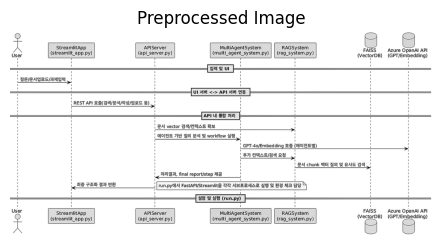

In [13]:
# Step 1: preprocess_image 테스트
# preprocess_image는 원본 컬러 이미지를 반환합니다 (EasyOCR은 컬러 이미지도 처리 가능)
import cv2
import matplotlib.pyplot as plt

img = preprocess_image(IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"이미지 shape: {img.shape}")
print(f"이미지 dtype: {img.dtype}")
print(f"채널 수: {img.shape[2] if len(img.shape) == 3 else 1}")

# 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Preprocessed Image")
plt.imshow(img)
plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title("Image for OCR (RGB)")
# plt.imshow(img_rgb)
# plt.axis('off')

# plt.tight_layout()
# plt.show()


c:\Users\INSoft\miniconda3\envs\sk\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


탐지된 단어 개수: 40

처음 10개 단어:
  [1] 'RAGSystem' at (1565, 72) conf=88% line=1
  [2] 'MultiAgentSystem' at (1209, 77) conf=87% line=1
  [3] 'StreamlitApp' at (263, 79) conf=70% line=1
  [4] 'APIServer' at (772, 80) conf=99% line=1
  [5] 'Azure OpenAl API' at (2179, 95) conf=61% line=1
  [6] 'FAISS' at (2040, 96) conf=73% line=1
  [7] '(strearlit_app:py)' at (226, 105) conf=29% line=1
  [8] '(multi_agent_system py)' at (1164, 106) conf=77% line=1
  [9] '(api_serverpy)' at (733, 107) conf=67% line=1
  [10] '(rag_systempy)' at (1536, 108) conf=77% line=1


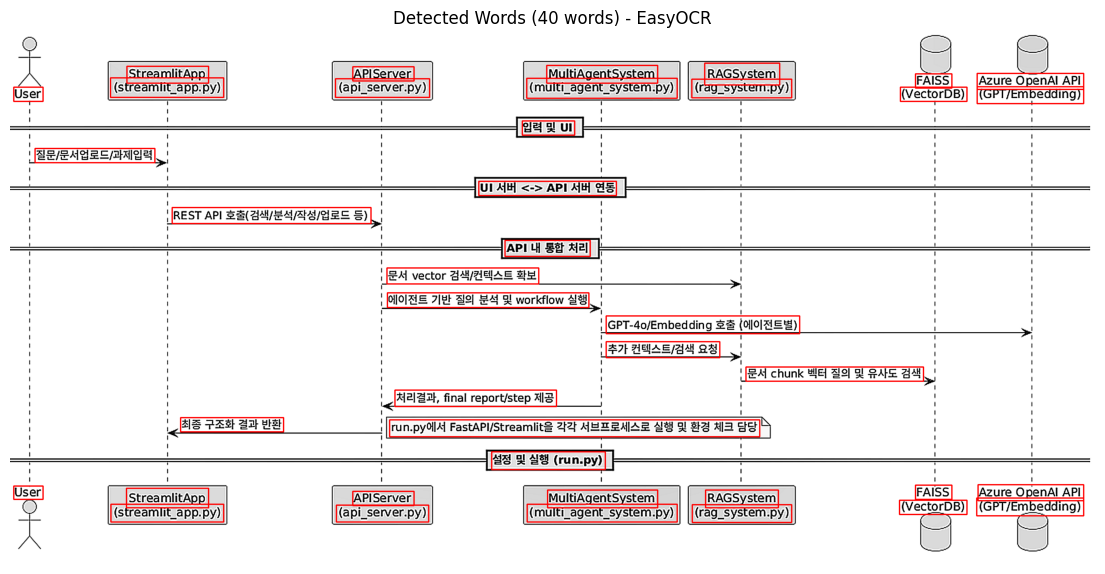

In [14]:
# Step 2: ocr_with_structure 테스트 (EasyOCR 사용)
# 핵심: EasyOCR이 직접 단어 단위로 탐지! (한국어+영어 지원)
# 주의: 첫 실행 시 모델 다운로드가 필요할 수 있습니다 (1-2분 소요)

words_data = ocr_with_structure(img, level='word', langs=['ko', 'en'])

print(f"탐지된 단어 개수: {len(words_data)}")
print(f"\n처음 10개 단어:")
for i, w in enumerate(words_data[:10]):
    print(f"  [{i+1}] '{w['text']}' at ({w['x']}, {w['y']}) conf={w['conf']}% line={w.get('line_num', 'N/A')}")

# 시각화: 탐지된 단어 박스 표시
img_with_boxes = img_rgb.copy()
for w in words_data:
    cv2.rectangle(img_with_boxes, (w['x'], w['y']), (w['x']+w['w'], w['y']+w['h']), (255, 0, 0), 2)

plt.figure(figsize=(14, 8))
plt.title(f"Detected Words ({len(words_data)} words) - EasyOCR")
plt.imshow(img_with_boxes)
plt.axis('off')
plt.show()


그룹화된 라인 개수: 40

각 라인 내용 (처음 15개):
  Line 1 (line_num=0): 'RAGSystem'
  Line 2 (line_num=1): 'MultiAgentSystem'
  Line 3 (line_num=2): 'StreamlitApp'
  Line 4 (line_num=3): 'APIServer'
  Line 5 (line_num=4): 'Azure OpenAl API'
  Line 6 (line_num=5): 'FAISS'
  Line 7 (line_num=6): '(strearlit_app:py)'
  Line 8 (line_num=7): '(multi_agent_system py)'
  Line 9 (line_num=8): '(api_serverpy)'
  Line 10 (line_num=9): '(rag_systempy)'
  Line 11 (line_num=10): '(GPTIEmbedding)'
  Line 12 (line_num=11): 'User'
  Line 13 (line_num=12): '(VectorDB)'
  Line 14 (line_num=13): '입력 및 UI'
  Line 15 (line_num=14): '질문 문서업로드과제입력'
  ... (총 40개 라인)


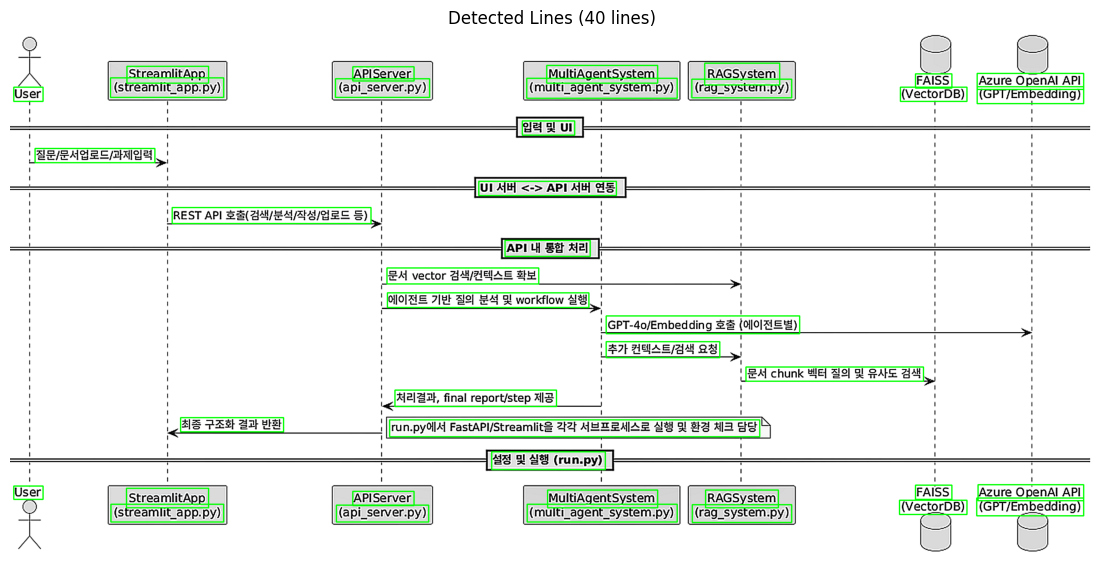

In [15]:


# Step 3: group_by_line 테스트 (라인 단위 그룹화)
lines_data = group_by_line(words_data)

print(f"그룹화된 라인 개수: {len(lines_data)}")
print(f"\n각 라인 내용 (처음 15개):")
for i, line in enumerate(lines_data[:15]):
    preview = line['text'][:60] + '...' if len(line['text']) > 60 else line['text']
    print(f"  Line {i+1} (line_num={line.get('line_num', 'N/A')}): '{preview}'")

if len(lines_data) > 15:
    print(f"  ... (총 {len(lines_data)}개 라인)")

# 시각화: 라인 박스 표시
img_with_lines = img_rgb.copy()
for line in lines_data:
    cv2.rectangle(img_with_lines, (line['x'], line['y']), 
                  (line['x']+line['w'], line['y']+line['h']), (0, 255, 0), 2)

plt.figure(figsize=(14, 8))
plt.title(f"Detected Lines ({len(lines_data)} lines)")
plt.imshow(img_with_lines)
plt.axis('off')
plt.show()


그룹화된 문단 개수: 1

각 문단 내용 (처음 10개):
  Paragraph 1 (para_num=0): 'RAGSystem MultiAgentSystem StreamlitApp APIServer Azure OpenAl API FAISS (strear...'


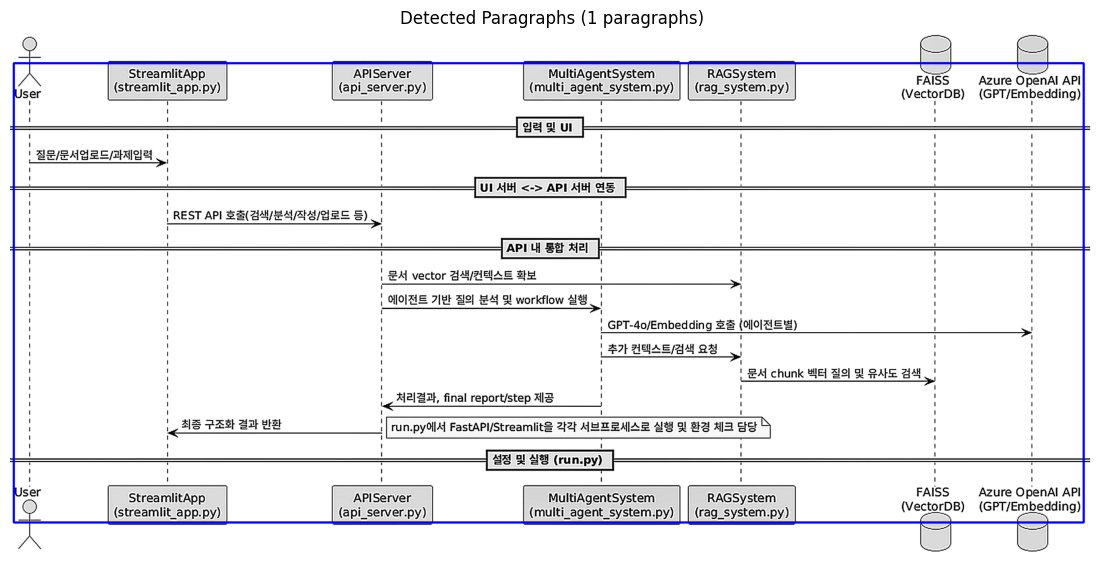

In [16]:
# Step 4: group_by_paragraph 테스트 (문단 단위 그룹화)
# 라인 간격 기반으로 문단 구성 (평균 라인 높이의 1.5배 이상이면 새 문단)
paragraphs_data = group_by_paragraph(words_data, para_threshold_ratio=1.5)

print(f"그룹화된 문단 개수: {len(paragraphs_data)}")
print(f"\n각 문단 내용 (처음 10개):")
for i, para in enumerate(paragraphs_data[:10]):
    preview = para['text'][:80] + '...' if len(para['text']) > 80 else para['text']
    print(f"  Paragraph {i+1} (para_num={para.get('paragraph_num', 'N/A')}): '{preview}'")

if len(paragraphs_data) > 10:
    print(f"  ... (총 {len(paragraphs_data)}개 문단)")

# 시각화: 문단 박스 표시
img_with_paras = img_rgb.copy()
for para in paragraphs_data:
    cv2.rectangle(img_with_paras, (para['x'], para['y']), 
                  (para['x']+para['w'], para['y']+para['h']), (0, 0, 255), 3)

plt.figure(figsize=(14, 8))
plt.title(f"Detected Paragraphs ({len(paragraphs_data)} paragraphs)")
plt.imshow(img_with_paras)
plt.axis('off')
plt.show()


In [17]:
# Step 5: 전체 텍스트 생성 (LLM에 보낼 텍스트)
# 라인 단위로 전체 텍스트 생성
full_text = generate_text_from_data(lines_data)

print("="*60)
print("추출된 전체 텍스트 (라인 단위):")
print("="*60)
print(full_text)
print("="*60)
print(f"\n총 {len(full_text)} 글자")


추출된 전체 텍스트 (라인 단위):
RAGSystem
MultiAgentSystem
StreamlitApp
APIServer
Azure OpenAl API
FAISS
(strearlit_app:py)
(multi_agent_system py)
(api_serverpy)
(rag_systempy)
(GPTIEmbedding)
User
(VectorDB)
입력 및 UI
질문 문서업로드과제입력
UI 서버 <-> API 서버 연동
REST API 호출(검색분석)작성 업로드 등)
API 내 동합 처리
문서 vector 검색컨텍스트 확보
에이전트 기반 질의 분석 및 workflow 실행
GPT-4olEmbedding 호출 (에이전트별)
추가 건텍스트검색 요청
문서 chunk 백터 질의 및 유사도 검색
처리결과, final reportistep 제공
최종 구조화 결과 반환
run-py에서 FastAPVStreamlit올 각각 서브프로세스로 실행 및 환경 체크 담당
설정 및 실행 (run-py)
Azure OpenAl API
FAISS
User
StreamlitApp
MultiAgentSystem
RAGSystem
APIServer
(GPTIEmbedding)
(VectorDB)
(streamlit_app.py)
(multi_agent_system py)
(rag_systempy)
(api_server py)

총 658 글자


In [18]:
# Step 5.5: OCR 교정 (LLM을 활용한 오타 수정)
# OCR 결과에 포함된 오류를 LLM으로 자동 교정
LLM_SERVER_URL = "http://gpurent.kogrobo.com:51089/v1"

print("[INFO] OCR 교정 시작...")
print("원본 텍스트에 오류가 있는지 확인하고 수정합니다...\n")

# 전체 텍스트를 LLM으로 교정
corrected_text = call_llm_for_correction(full_text, LLM_SERVER_URL)

if corrected_text != full_text:
    print("="*60)
    print("교정 결과:")
    print("="*60)
    
    # 교정된 텍스트를 라인별로 분할하여 lines_data 업데이트
    corrected_lines = corrected_text.split('\n')
    
    print(f"교정 전 라인 수: {len(lines_data)}")
    print(f"교정 후 라인 수: {len(corrected_lines)}")
    
    # lines_data 업데이트
    for i, line_item in enumerate(lines_data):
        if i < len(corrected_lines):
            original = line_item['text']
            corrected = corrected_lines[i].strip()
            line_item['text'] = corrected
            line_item['corrected'] = (original != corrected)
            
            # 변경된 라인만 표시
            if original != corrected:
                print(f"\n[수정] Line {i+1}:")
                print(f"  원본: {original}")
                print(f"  교정: {corrected}")
        else:
            line_item['corrected'] = False
    
    # 교정된 전체 텍스트 업데이트
    full_text = corrected_text
    
    print("\n" + "="*60)
    print("교정 완료!")
    print("="*60)
else:
    print("[INFO] OCR 교정: 변경사항 없음 (오류가 없거나 감지되지 않음)")
    # 교정되지 않았음을 표시
    for line_item in lines_data:
        line_item['corrected'] = False

print(f"\n교정된 전체 텍스트 (처음 300글자):")
print("-"*60)
print(full_text[:300] + "..." if len(full_text) > 300 else full_text)
print("-"*60)


[INFO] OCR 교정 시작...
원본 텍스트에 오류가 있는지 확인하고 수정합니다...

교정 결과:
교정 전 라인 수: 40
교정 후 라인 수: 43

[수정] Line 5:
  원본: Azure OpenAl API
  교정: Azure OpenAI API

[수정] Line 7:
  원본: (strearlit_app:py)
  교정: (streamlit_app.py)

[수정] Line 8:
  원본: (multi_agent_system py)
  교정: (multi_agent_system.py)

[수정] Line 9:
  원본: (api_serverpy)
  교정: (api_server.py)

[수정] Line 10:
  원본: (rag_systempy)
  교정: (rag_system.py)

[수정] Line 11:
  원본: (GPTIEmbedding)
  교정: (GPTEmbedding)

[수정] Line 14:
  원본: 입력 및 UI
  교정: 

[수정] Line 15:
  원본: 질문 문서업로드과제입력
  교정: 입력 및 UI

[수정] Line 16:
  원본: UI 서버 <-> API 서버 연동
  교정: 질문 문서 업로드 및 과제 입력

[수정] Line 17:
  원본: REST API 호출(검색분석)작성 업로드 등)
  교정: UI 서버 <-> API 서버 연동

[수정] Line 18:
  원본: API 내 동합 처리
  교정: REST API 호출(검색·분석·작성·업로드 등)

[수정] Line 19:
  원본: 문서 vector 검색컨텍스트 확보
  교정: API 내 동시 처리

[수정] Line 20:
  원본: 에이전트 기반 질의 분석 및 workflow 실행
  교정: 문서 vector 검색 컨텍스트 확보

[수정] Line 21:
  원본: GPT-4olEmbedding 호출 (에이전트별)
  교정: 에이전트 기반 질의 분석 및 workflow 실행

[수정] Line 22:
  원본: 추가 건텍스트검색 요청
 

In [21]:
# Step 6: LLM 내용 설명 생성
# 교정된 텍스트(full_text)를 사용하여 이미지 내용 설명 생성
# LLM_SERVER_URL은 Step 5.5에서 이미 정의됨

print("[INFO] LLM에 텍스트 전송 중...")
print("교정된 텍스트를 기반으로 이미지 내용을 분석합니다...\n")

description = call_llm_for_description(full_text, LLM_SERVER_URL)

if description:
    print("\n" + "="*60)
    print("LLM 이미지 내용 설명:")
    print("="*60)
    print(description)
    print("="*60)
else:
    print("[WARN] LLM 설명이 생성되지 않았습니다.")


[INFO] LLM에 텍스트 전송 중...
교정된 텍스트를 기반으로 이미지 내용을 분석합니다...


LLM 이미지 내용 설명:
이 그림은 **RAG (Retrieval‑Augmented Generation) 기반 멀티‑에이전트 시스템**의 전체 아키텍처와 동작 흐름을 한눈에 보여주는 블록 다이어그램입니다.  
아래와 같이 주요 구성 요소와 데이터 흐름을 정리할 수 있습니다.

---

## 1. 전체 구성 요소

| 구분 | 컴포넌트 | 설명 |
|------|----------|------|
| **사용자 인터페이스** | **StreamlitApp** ( `streamlit_app.py` ) | 웹 UI를 제공하는 프론트엔드. 사용자는 여기서 **문서 업로드**와 **질문·과제 입력**을 수행한다. |
| **API 서버** | **APIServer** ( `api_server.py` ) | FastAPI 기반 백엔드. UI와 내부 로직을 연결하고, 외부·내부 **REST API** 호출을 담당한다. |
| **핵심 로직** | **RAGSystem** ( `rag_system.py` )<br>**MultiAgentSystem** ( `multi_agent_system.py` ) | - **RAGSystem**: 문서 → 벡터 변환 → 검색 → 컨텍스트 제공 → 최종 응답 생성.<br>- **MultiAgentSystem**: 질문을 분석하고, 필요한 작업(검색, 요약, 작성 등)을 여러 에이전트에게 분배·조정한다. |
| **임베딩·벡터 저장소** | **GPTEmbedding** (Azure OpenAI API) <br>**FAISS** (VectorDB) | - **GPTEmbedding**: Azure OpenAI의 `text‑embedding‑ada‑002` 등 모델을 이용해 문서 조각(chunk)을 고차원 벡터로 변환한다.<br>- **FAISS**: 생성된 벡터를 저장·인덱싱하고, **유사도 검색**을 빠르게 수행한다. |
| **실행·관리 

In [20]:
# Step 7: 결과 저장
TXT_PATH = "output/output.txt"
CSV_PATH = "output/output.csv"

# 라인 단위로 저장
save_output(lines_data, TXT_PATH, CSV_PATH, description)

print(f"[완료] TXT 저장: {TXT_PATH}")
print(f"[완료] CSV 저장: {CSV_PATH}")
print(f"[완료] 저장된 라인 수: {len(lines_data)}")

# 저장된 파일 미리보기
print("\n" + "="*60)
print("저장된 TXT 파일 내용 (미리보기 - 처음 500글자):")
print("="*60)
with open(TXT_PATH, 'r', encoding='utf-8') as f:
    content = f.read()
    print(content[:500] + "..." if len(content) > 500 else content)
    print(f"\n... (총 {len(content)} 글자)")


[완료] TXT 저장: output/output.txt
[완료] CSV 저장: output/output.csv
[완료] 저장된 라인 수: 40

저장된 TXT 파일 내용 (미리보기 - 처음 500글자):

이미지 내용 설명:
이 그림은 **RAG‑(Retrieval‑Augmented Generation) 기반 멀티‑에이전트 시스템**의 전체 구조와 흐름을 한눈에 보여주는 아키텍처 다이어그램입니다.  
아키텍처는 크게 **사용자 UI**, **API 서버**, **RAG‑코어**, **멀티‑에이전트 엔진**, **벡터 데이터베이스**, **Azure OpenAI**(GPT‑4 Embedding) 로 구성되며, 각 요소가 어떻게 연결되고 어떤 역할을 하는지 단계별로 설명하면 다음과 같습니다.

---

## 1. 전체 구성 요소

| 구분 | 파일·모듈 | 역할 |
|------|-----------|------|
| **프론트엔드** | `StreamlitApp` ( `...

... (총 1943 글자)
